In [ ]:
!pip install torch torchvision matplotlib opencv-python pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import os

# MAIN_PATH = os.path.join("drive", "MyDrive", "Colab Notebooks", "training_model")
MAIN_PATH = os.path.join(".")

Mounted at /content/drive


In [ ]:
import os

In [ ]:
DATA_FOLDER = os.path.join(MAIN_PATH, "data")
IMAGES_FOLDER = os.path.join(DATA_FOLDER, "images")

In [ ]:
import torch

BATCH_SIZE = 4
RESIZE_TO = 512

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CLASSES = ['background', 'Face']
NUM_CLASSES = 2

In [ ]:
torch.cuda.is_available()

True

In [ ]:
import pandas as pd
import os

def train_valid_test_split(faces_csv=None, split=0.15):
    all_df = pd.read_csv(faces_csv)
    all_df = all_df.sample(n=500, random_state=7)
    all_df.sample(frac=1)
    len_df = len(all_df)
    trainTest_split = int((1-split)*len_df)
    trainVal_df = all_df[:trainTest_split]
    test_df = all_df[trainTest_split:]
    lenTV_df = len(trainVal_df)
    trainVal_split = int((1-split)*lenTV_df)
    train_df = trainVal_df[:trainVal_split]
    valid_df = trainVal_df[trainVal_split:]

    return train_df, valid_df, test_df

train_df, valid_df, test_df = train_valid_test_split(faces_csv=os.path.join(DATA_FOLDER, "faces.csv"))

In [ ]:
import cv2
import numpy as np

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
import glob as glob
from torch.utils.data import Dataset, DataLoader

class Faces(Dataset):
    def __init__(self, dataset, width, height, dir_path=IMAGES_FOLDER):
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.dataset = dataset

        self.set_image_names = self.dataset['image_name'].tolist()

        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

        self.images = []

        for i in self.set_image_names:
            for j in self.all_images:
                if i == j:
                    self.images.append(i)

    def __getitem__(self, idx):

        image_name = self.images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        image = cv2.imread(image_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        image_resized = np.transpose(image_resized, (2, 0, 1))

        boxes = []
        labels = []

        filtered_df = self.dataset.loc[self.dataset['image_name'] == image_name]

        for i in range(len(filtered_df)):

            xmin = int(filtered_df['x0'].iloc[i])
            xmax = int(filtered_df['x1'].iloc[i])
            ymin = int(filtered_df['y0'].iloc[i])
            ymax = int(filtered_df['y1'].iloc[i])

            image_width = int(filtered_df['width'].iloc[i])
            image_height = int(filtered_df['height'].iloc[i])

            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height

            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
            labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        if boxes.shape[0] > 1:
            iscrowd = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        return image_resized, target

    def __len__(self):
        return len(self.set_image_names)

In [ ]:
train_dataset = Faces(train_df, RESIZE_TO, RESIZE_TO)
valid_dataset = Faces(valid_df, RESIZE_TO, RESIZE_TO)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 361
Number of validation samples: 64


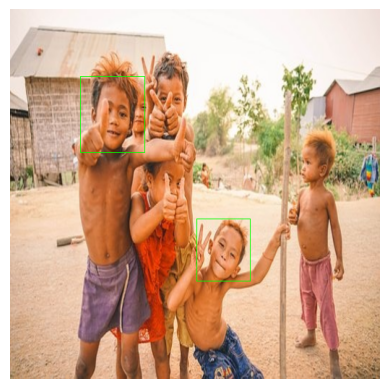

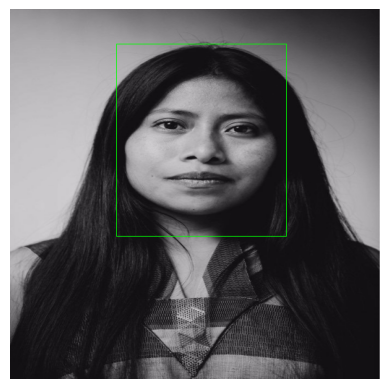

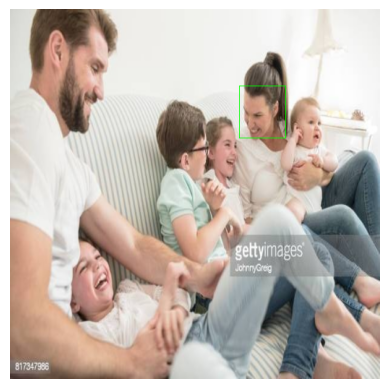

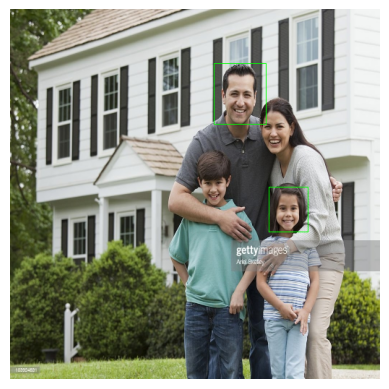

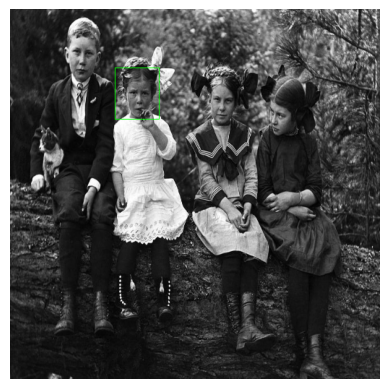

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(image, target):
    for box in target['boxes']:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1
        )

    plt.imshow(image)
    plt.axis('off')
    plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    visualize_sample(image, target)

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(torch.from_numpy(image).to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(torch.from_numpy(image).to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 154MB/s]



EPOCH 1 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #1 train loss: 0.287
Epoch #1 validation loss: 0.190
Took 7.291 minutes for epoch 1

EPOCH 2 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #2 train loss: 0.173
Epoch #2 validation loss: 0.154
Took 1.325 minutes for epoch 2

EPOCH 3 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #3 train loss: 0.146
Epoch #3 validation loss: 0.121
Took 1.309 minutes for epoch 3

EPOCH 4 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #4 train loss: 0.126
Epoch #4 validation loss: 0.116
Took 1.310 minutes for epoch 4

EPOCH 5 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #5 train loss: 0.118
Epoch #5 validation loss: 0.114
Took 1.310 minutes for epoch 5

EPOCH 6 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #6 train loss: 0.109
Epoch #6 validation loss: 0.115
Took 1.317 minutes for epoch 6

EPOCH 7 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #7 train loss: 0.107
Epoch #7 validation loss: 0.114
Took 1.311 minutes for epoch 7

EPOCH 8 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #8 train loss: 0.100
Epoch #8 validation loss: 0.112
Took 1.311 minutes for epoch 8

EPOCH 9 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #9 train loss: 0.092
Epoch #9 validation loss: 0.108
Took 1.317 minutes for epoch 9

EPOCH 10 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #10 train loss: 0.086
Epoch #10 validation loss: 0.113
Took 1.313 minutes for epoch 10

EPOCH 11 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #11 train loss: 0.080
Epoch #11 validation loss: 0.109
Took 1.303 minutes for epoch 11

EPOCH 12 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #12 train loss: 0.078
Epoch #12 validation loss: 0.115
Took 1.304 minutes for epoch 12

EPOCH 13 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #13 train loss: 0.072
Epoch #13 validation loss: 0.108
Took 1.304 minutes for epoch 13

EPOCH 14 of 30
Training


  0%|          | 0/91 [00:00<?, ?it/s]

Validating


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch #14 train loss: 0.067
Epoch #14 validation loss: 0.112
Took 1.310 minutes for epoch 14
Early stopping


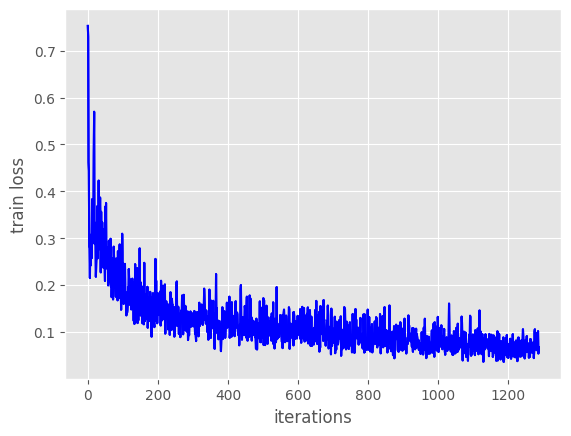

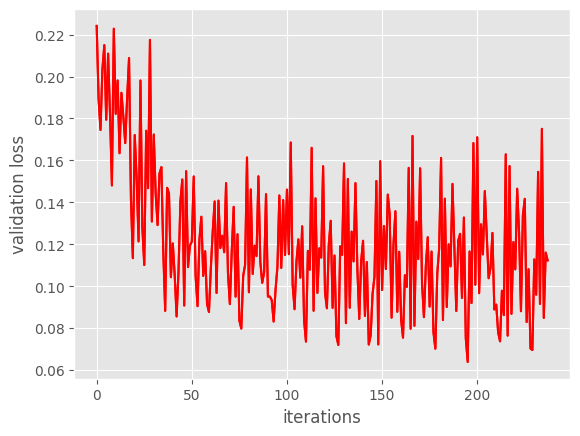

In [ ]:
import torch

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time

plt.style.use('ggplot')

NUM_EPOCHS = 30
MODEL_NAME = 'model1'
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

patience = 5
min_delta = 0.001
best_val_loss = float('inf')

train_loss_list = []
val_loss_list = []
early_stopping_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    train_loss_hist.reset()
    val_loss_hist.reset()

    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    train_loss_list.append(train_loss_hist.value)
    val_loss_list.append(val_loss_hist.value)

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    if val_loss_hist.value + min_delta < best_val_loss:
        best_val_loss = val_loss_hist.value
        early_stopping_counter = 0
        torch.save(model.state_dict(), os.path.join(MAIN_PATH, MODEL_NAME + ".pth"))
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience or (epoch+1) == NUM_EPOCHS:
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')

        if early_stopping_counter >= patience:
            print("Early stopping")
            break


train_ax.plot(train_loss, color='blue')
train_ax.set_xlabel('iterations')
train_ax.set_ylabel('train loss')

valid_ax.plot(val_loss, color='red')
valid_ax.set_xlabel('iterations')
valid_ax.set_ylabel('validation loss')
plt.show()

Test instances: 75


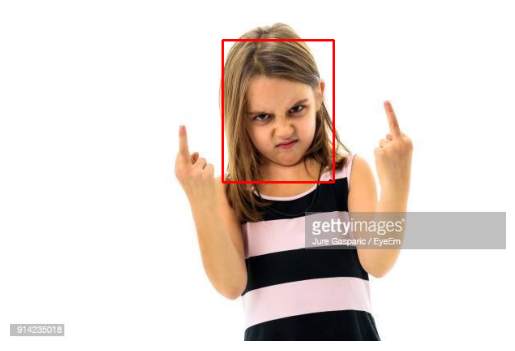

Image 17 done...
--------------------------------------------------


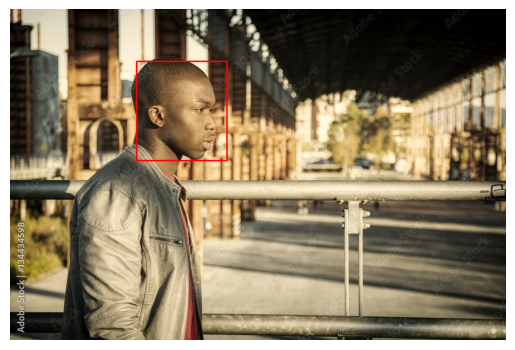

Image 7 done...
--------------------------------------------------


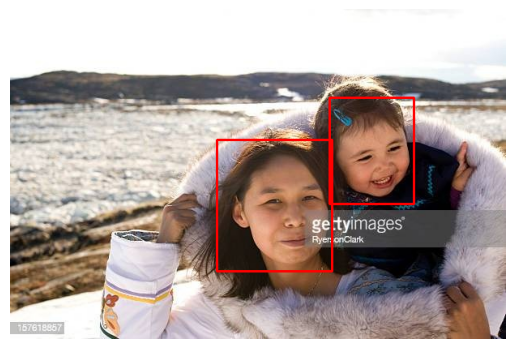

Image 67 done...
--------------------------------------------------


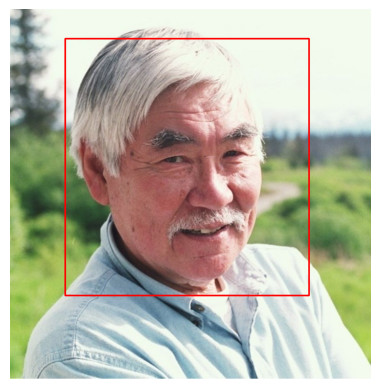

Image 24 done...
--------------------------------------------------


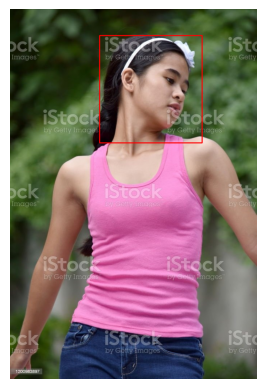

Image 36 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [ ]:
import random
model.eval()

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

# copy image names to list
test_image_names = test_df['image_name'].tolist()

# get all the image names in sorted order
dir_path=IMAGES_FOLDER
image_paths = glob.glob(f"{dir_path}/*.jpg")
all_images = [image_path.split('/')[-1] for image_path in image_paths]
all_images = sorted(all_images)

# get paths of only images present in dataset
test_images = []

for i in test_image_names:
    for j in all_images:
        if i == j:
            test_images.append(os.path.join(dir_path, i))


print(f"Test instances: {len(test_images)}")

for i in random.sample(range(len(test_images)), 5):
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(float)
    image = torch.tensor(image, dtype=torch.float).cuda()
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)

    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()

        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
        image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')